# Data Cleaning

In [242]:
import pandas as pd
import pyarrow
import os
import matplotlib.pyplot as plt
folder_path = os.getenv("MY_WORKSPACE", 'empty') + '/acl_spring_24_bulls2'
os.chdir(folder_path)

4 types of data are provided: 

1. Ticket Sales Data - sales data from the tickets purchased and scanned at the United Center

2. Email Engagement Data - these contain information about interactions attendees have with the emails sent before and after the game. There are two categories of files (send and clickthrough) for two types of emails (KBYG and postgame).

    * KBYG - know before you go emails are the pre-game emails
        
        1. Send Details

        2. Clickthrough Data

    * Postgame - postgame emails sent after the game
        
        1. Send Details

        2. Clickthrough Data

3. LiveA Demographic Data - 3rd Party Provider data to augment with ticket sales and email engagment data to profile individuals with demographic characteristics

4. Bulls Theme + Giveaway Schedule - schedule of promotional activity for each game. 



## Ticket Sales Data Cleaning

In [243]:
#Import ticket sales data
tickets = pd.read_csv("/Users/jm/working/acl_spring_24_bulls2/data/raw/Ticket Sales Data/22-23 & 23-24 (through 3.14) Ticket Sales Data.csv", 
                      names = [
                        'season_name', 'event_date', 'event_weekday', 'opponent_short',
                        'parent_ticket_categories', 'add_date', 'days_before_event',
                        'purchaser_email', 'total_seats', 'seat_location', 'seat_level',
                        'arrival_time', 'attendee_email', 'attendee_zip_code', 'mobile_scan',
                        'scan_category'
                    ],
                    header = 0
                )



In [244]:
# Fix Date Data Types
tickets["event_date"] = pd.to_datetime(tickets['event_date'], format = "%d-%b-%y")#.astype(str)

tickets["add_date"] = pd.to_datetime(tickets['add_date'], format = "%d-%b-%y")#.astype(str)

tickets["arrival_time"] = pd.to_datetime(tickets['arrival_time'], format = "%m/%d/%y %H:%M")

In [245]:
# Convert mobile_scan to a boolean
tickets['mobile_scan'] = tickets.mobile_scan.astype("bool")

### Ticket Sales Data Overview

This data represents tickets redeemed at the United Center for Chicago Bulls home games. Column names have been renamed to be more code-friendly. Below is the data dictionary:

### Event Information
| Code Friendly Name        | Description                                                  | Detail                                         | Field Type |
|---------------------------|--------------------------------------------------------------|------------------------------------------------|------------|
| season_name               | Indicates the NBA season of each event                       | NBA season runs from October to April          | CHARACTER  |
| event_date                | The date of the game for which tickets were redeemed         |                                                | DATE       |
| event_weekday             | The day of the week each game was held                       |                                                | CHARACTER  |
| opponent_short            | The nickname of the opposing team (city/location excluded)   | Example: Lakers, Pelicans                      | CHARACTER  |

### Ticket Purchase Information
| Code Friendly Name        | Description                                                  | Detail                                         | Field Type |
|---------------------------|--------------------------------------------------------------|------------------------------------------------|------------|
| parent_ticket_categories  | Type of ticket purchased                                     | Group = group purchases, Individual: Resale Buyer, Package = Subscription | CHARACTER  |
| add_date                  | Date the tickets were purchased/added                        |                                                | DATE       |
| days_before_event         | Days in advance the ticket was purchased                     | Calculated from Add Date and Event Date        | INTEGER    |
| purchaser_email           | Email contact associated with the purchase record            |                                                | CHARACTER  |
| total_seats               | Total number of seats purchased in the transaction           |                                                | INTEGER    |
| seat_location             | Location in the United Center where the seats are located    | 100 Level = lower bowl of seats                 | CHARACTER  |
| seat_level                | Level of seat access within the United Center                | Lower Level = 100 Level, Club Level = 200 and 300 levels | CHARACTER  |

### Attendance Information
| Code Friendly Name        | Description                                                  | Detail                                         | Field Type |
|---------------------------|--------------------------------------------------------------|------------------------------------------------|------------|
| arrival_time              | DateTime of ticket scan at the gate                          | Blank = Un-scanned ticket                      | DATETIME   |
| attendee_email            | Email contact associated with the attendee                   |                                                | CHARACTER  |
| attendee_zip_code         | Zip code of the attendee's address                           |                                                | INTEGER    |
| mobile_scan               | Indicates if the ticket was scanned using a mobile device    | 1 = Mobile scan, 0 = Non-mobile scan, Blank = Un-scanned | BINARY     |
| scan_category             | Method used by the attendee to access the event              |                                                | CHARACTER  |

This dictionary serves as a reference for understanding and utilizing the data fields related to ticket sales for Chicago Bulls home games at the United Center.


In [246]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570265 entries, 0 to 570264
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   season_name               570265 non-null  object        
 1   event_date                570265 non-null  datetime64[ns]
 2   event_weekday             570265 non-null  object        
 3   opponent_short            570265 non-null  object        
 4   parent_ticket_categories  570265 non-null  object        
 5   add_date                  570265 non-null  datetime64[ns]
 6   days_before_event         570265 non-null  int64         
 7   purchaser_email           563715 non-null  object        
 8   total_seats               570265 non-null  int64         
 9   seat_location             570265 non-null  object        
 10  seat_level                570265 non-null  object        
 11  arrival_time              526213 non-null  datetime64[ns]
 12  at

Filter to just the season ticket holders using the 'parent_ticket_categories' variable.

In [247]:
season_tickets = tickets[tickets['parent_ticket_categories'] == "Season"]

In [248]:
season_tickets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270086 entries, 300179 to 570264
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   season_name               270086 non-null  object        
 1   event_date                270086 non-null  datetime64[ns]
 2   event_weekday             270086 non-null  object        
 3   opponent_short            270086 non-null  object        
 4   parent_ticket_categories  270086 non-null  object        
 5   add_date                  270086 non-null  datetime64[ns]
 6   days_before_event         270086 non-null  int64         
 7   purchaser_email           268908 non-null  object        
 8   total_seats               270086 non-null  int64         
 9   seat_location             270086 non-null  object        
 10  seat_level                270086 non-null  object        
 11  arrival_time              237206 non-null  datetime64[ns]
 12  at

### Ticket Sales Data Summary

There are 270,068 season ticket purchasers that were scanned at Chicago Bulls games at the United Center over the 2022-2023 season and 2023-2024 (through March 19th) season. The data contains 15 columns. 

There are missing values in the `purchaser_email`, `attendee_email`, `arrival_time`, and `attendee_zip_code` columns.



## Game Data Cleaning

It may be important to look at data from the season. Here we have imported game data that shows the score, win streak, etc., for each regular season game. 

### Games Data Overview

This data represents games played by the Chicago Bulls and the results. Below is the data dictionary:

### Data Dictionary
| Code Friendly Name        | Description                                                  | Detail                                         | Field Type |
|---------------------------|--------------------------------------------------------------|------------------------------------------------|------------|
| season_name               | Indicates the NBA season of each event                       | NBA season runs from October to April          | CHARACTER  |
| G                         | Game number of the season                                    |                                                | INT        |
| event_date                | date of the game                                             |                                                | DATE       |
| start_ct                  | dstart time of the game in central time                      |                                                | DATE       |
| away                      | 1 if away and 0 if home game                                 |                                                | INT        |
| Opponent                  | full name of opponent                                        |                                                | CHARACTER  |
| outcome                   | Win or Loss (W or L)                                         |                                                | CHARACTER  |
| overtime                  | Did it go to overtime?                                       |                                                | CHARACTER  |
| pts                       | points scored                                                |                                                | INT        |
| pts_all                   | points allowed                                               |                                                | INT        |
| W                         | wins to date                                                 |                                                | INT        |
| L                         | losses to date                                               |                                                | INT        |
| Streak                    | Streak                                                       |             e.g., 'W 4'    or 'L 2             | CHARACTER  |
| Notes                     | misc notes                                                   |                                                | CHARACTER  |

In [249]:
s23 = pd.read_csv("/Users/jm/working/acl_spring_24_bulls2/data/bulls2223_season.csv")
s24 = pd.read_csv("/Users/jm/working/acl_spring_24_bulls2/data/bulls2324_season.csv")

In [250]:
def convert_time(time_str):
    return time_str.replace('p', ' PM').replace('a', ' AM')

def prep_season_games(season_data, season:str):
    season_data['season_name'] = season

    season_data["start_et"] = season_data['date'] + ' ' + season_data['start_et'].apply(convert_time)
    season_data["start_et"] = pd.to_datetime(season_data['start_et'], format = "%a %b %d %Y %I:%M %p")
    season_data['event_date'] = pd.to_datetime(season_data['date'], format = "%a %b %d %Y")#.astype(str)

    # Convert to central time zone
    season_data["start_ct"] =  season_data["start_et"] - pd.Timedelta(hours=1)

    return season_data

s23 = prep_season_games(s23, season = "2022-2023 Chicago Bulls")[
    [
        "season_name", "G", "event_date", "start_ct", "away", 
        "Opponent", "outcome", "overtime", "pts", "pts_all",
        "W", "L", "Streak", "Notes"
        ]
    ]

s24 = prep_season_games(s24, season = "2023-2024 Chicago Bulls")[
    [
        "season_name", "G", "event_date", "start_ct", "away", 
        "Opponent", "outcome", "overtime", "pts", "pts_all",
        "W", "L", "Streak", "Notes"
        ]
    ]

In [251]:
bulls2224_games = pd.concat([s23, s24])

In [252]:
# Filter for home games
home_games = bulls2224_games[bulls2224_games['away'] == 0].drop('away', axis = 1)

In [253]:
home_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 2 to 72
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   season_name  79 non-null     object        
 1   G            79 non-null     int64         
 2   event_date   79 non-null     datetime64[ns]
 3   start_ct     79 non-null     datetime64[ns]
 4   Opponent     79 non-null     object        
 5   outcome      79 non-null     object        
 6   overtime     79 non-null     object        
 7   pts          79 non-null     int64         
 8   pts_all      79 non-null     int64         
 9   W            79 non-null     int64         
 10  L            79 non-null     int64         
 11  Streak       79 non-null     object        
 12  Notes        2 non-null      object        
dtypes: datetime64[ns](2), int64(5), object(6)
memory usage: 8.6+ KB


## Email Engagement Data Cleaning

The email engagment data is broken into two files corresponding to the pre-game and post-game email schedule. One email is sent before every Chicago Bulls game and another is sent after every game. The data collected in both of these files represents the clickthrough data for both types of email sent. Both files contain data for both the '22 - '23 season and '23 - '24 season. 

Everytime an attendee clicks a link on one of these emails a row is entered. 

The two types of email engagment data are: 
1. KBYG - Know Before You Go: these emails are sent before the game to ticket holders with pre-game instructions. Usually sent the same day. 
2. Post-Game: These emails are sent after the game with promotional material. 

Each of these types is complemented with send details data and clickthrough data.


### Email Send - Data Dictionary

We will rename the columns to make them more code friendly. Find the data dictionary below. 

| Variable Name                 | Code Friendly Name    | Description                                                   | Field Type |
|-------------------------------|-----------------------|---------------------------------------------------------------|------------|
| Email Send Date               | email_send_dt         | date and time the email was sent                              | DATE       |
| Email Group                   | email_group           | the email group as defined by the Bulls team                  | CHARACTER  |
| Email Name                    | email_name            | name of the email sent out                                    | CHARACTER  |
| Email Address                 | attendee_email        | email of the attendee of the game                             | CHARACTER  |
| Total Sends                   | total_sends           | number of sends                                               | INTEGER    |
| Total Delivered               | total_delivered       | number of delivers                                            | INTEGER    |
| Total Opens                   | total_opens           | number of opens                                               | INTEGER    |
| Unique Opens                  | unique_opens          | number of unique opens                                        | INTEGER    |
| Total Clickthroughs           | total_clickthroughs   | total count of click throughs                                 | INTEGER    |
| Unique Clickthroughs          | unique_clickthroughs  | the number of unique clickthroughs                            | INTEGER    |
| Season                        | season                | the season                                                    | CHARACTER  |
|                               | email_type            | the type of email: kbyg or post                               | CHARACTER  |



### Email Clickthrough - Data Dictionary

We will rename the columns to make them more code friendly. Find the data dictionary below. 

| Variable Name                 | Code Friendly Name    | Description                                                   | Field Type |
|-------------------------------|-----------------------|---------------------------------------------------------------|------------|
| Email Address                 | attendee_email        | email of the attendee of the game                             | CHARACTER  |
| Clickthrough Link             | clickthrough_url      | clickthrough link/URL                                         | CHARACTER  |
| Email Clickthrough Date/Time  | clickthrough_dt       | clickthrough date and time                                    | DATE       |
| Email Name                    | email_name            | name of the email sent out                                   | CHARACTER  |
| Total Clickthroughs           | total_clickthroughs   | total count of click throughs                                 | INTEGER    |
| Email Send Date               | email_send_dt         | date and time the email was sent                              | DATE       |
| Unique Clickthroughs          | unique_clickthroughs  | the number of unique clickthroughs                            | INTEGER    |
| Clickthrough Link Count       | clickthrough_link_count  | ????                                                       | INTEGER    |
| Season                        | season                | the season                                                    | CHARACTER  |
|                               | email_type            | the type of email: kbyg or post                               | CHARACTER  |

Since both data sets follow the same data structure we will concatenate the datasets. We have also added in a column to denote which type of email is sent. 

### Send Details Data Cleaning

In [254]:
# Load data from CSV file
#Email Address,  Clickthrough Link,  Email Clickthrough Date/Time,  Email Name,Total Clickthroughs,Email Send Date,Unique Clickthroughs,Clickthrough Link Count,Season

df_kbyg_send = pd.read_csv("data/raw/Email Engagement Data/KBYG_Send Details_2223 and 2324 Seasons.csv"
                 , 
                    header = 0
                )
df_kbyg_send['email_type'] = 'kbyg'

df_post_send = pd.read_csv("data/raw/Email Engagement Data/Postgame Email_Send Details_2223 and 2324 seasons.csv"
                 , 

                    header = 0
                )
df_post_send['email_type'] = 'post'

if sum(df_kbyg_send.columns.isin(df_post_send.columns)) == len(df_kbyg_send.columns):
    df_kbyg_send.columns =  [
                        'email_send_dt', 'email_group', 'email_name', 'attendee_email',
                        'total_sends', 'total_delivered', 'total_opens', 'unique_opens',
                        'total_clickthroughs', 'unique_clickthroughs', 'season', 'email_type'
    ]
    df_post_send.columns =  [
                        'email_send_dt', 'email_group', 'email_name', 'attendee_email',
                        'total_sends', 'total_delivered', 'total_opens', 'unique_opens',
                        'total_clickthroughs', 'unique_clickthroughs', 'season', 'email_type'
    ]

    df_emails_send = pd.concat([df_kbyg_send, df_post_send])

    df_emails_send["email_send_dt"] = pd.to_datetime(df_emails_send['email_send_dt'], format = "%m/%d/%y %H:%M")

In [255]:
df_emails_send.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628052 entries, 0 to 233577
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   email_send_dt         628052 non-null  datetime64[ns]
 1   email_group           628052 non-null  object        
 2   email_name            628052 non-null  object        
 3   attendee_email        628052 non-null  object        
 4   total_sends           627442 non-null  float64       
 5   total_delivered       627096 non-null  float64       
 6   total_opens           91879 non-null   float64       
 7   unique_opens          628052 non-null  int64         
 8   total_clickthroughs   27706 non-null   float64       
 9   unique_clickthroughs  628052 non-null  int64         
 10  season                628052 non-null  int64         
 11  email_type            628052 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory us

Now we have to filter for just those emails that correspond to season ticket holders from the tickets data. 

In [256]:
df_season_emails_send = df_emails_send[df_emails_send['attendee_email'].isin(season_tickets['attendee_email'].unique())]

In [257]:
df_season_emails_send.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222264 entries, 0 to 233571
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   email_send_dt         222264 non-null  datetime64[ns]
 1   email_group           222264 non-null  object        
 2   email_name            222264 non-null  object        
 3   attendee_email        222264 non-null  object        
 4   total_sends           222201 non-null  float64       
 5   total_delivered       222142 non-null  float64       
 6   total_opens           29666 non-null   float64       
 7   unique_opens          222264 non-null  int64         
 8   total_clickthroughs   5561 non-null    float64       
 9   unique_clickthroughs  222264 non-null  int64         
 10  season                222264 non-null  int64         
 11  email_type            222264 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory us

### Clickthrough Data Cleaning

In [258]:
# Load data from CSV file
#Email Address,  Clickthrough Link,  Email Clickthrough Date/Time,  Email Name,Total Clickthroughs,Email Send Date,Unique Clickthroughs,Clickthrough Link Count,Season

df_kbyg_ctr = pd.read_csv("data/raw/Email Engagement Data/KBYG Clickthrough Data_2223 and 2324 Seasons.csv"
                 , 
                      names = [
                        'attendee_email', 'clickthrough_url', 'clickthrough_dt',
                        'email_name', 'total_clickthroughs', 'email_send_dt',
                        'unique_clickthroughs', 'clickthrough_link_count', 'season'
                    ],
                    header = 0
                )
df_kbyg_ctr['email_type'] = 'kbyg'

df_post_ctr = pd.read_csv("data/raw/Email Engagement Data/Postgame Email Clickthrough_2223 and 2324 seasons.csv"
                 , 
                      names = [
                        'attendee_email', 'clickthrough_url', 'clickthrough_dt',
                        'email_name', 'total_clickthroughs', 'email_send_dt',
                        'unique_clickthroughs', 'clickthrough_link_count', 'season'
                    ],
                    header = 0
                )
df_post_ctr['email_type'] = 'post'

df_emails_ctr = pd.concat([df_kbyg_ctr, df_post_ctr])


In [259]:
# Fix Date Data Types
df_emails_ctr["clickthrough_dt"] = pd.to_datetime(df_emails_ctr['clickthrough_dt'], format = "%m/%d/%Y %H:%M")
df_emails_ctr["email_send_dt"] = pd.to_datetime(df_emails_ctr['email_send_dt'], format = "%m/%d/%Y %H:%M")

Now we have to filter for just those emails that correspond to season ticket holders from the tickets data. 

In [260]:
df_season_emails_ctr = df_emails_ctr[df_emails_ctr['attendee_email'].isin(season_tickets['attendee_email'].unique())]

In [261]:
df_season_emails_ctr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8158 entries, 1 to 23372
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   attendee_email           8158 non-null   object        
 1   clickthrough_url         8158 non-null   object        
 2   clickthrough_dt          8158 non-null   datetime64[ns]
 3   email_name               8158 non-null   object        
 4   total_clickthroughs      8158 non-null   int64         
 5   email_send_dt            8158 non-null   datetime64[ns]
 6   unique_clickthroughs     8158 non-null   int64         
 7   clickthrough_link_count  8158 non-null   int64         
 8   season                   8158 non-null   int64         
 9   email_type               8158 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 701.1+ KB


## Live Analytics Data Cleaning

The Live Anlaytics contains demographic data for ticketholder attendees. 

See the data dictionary for relevant information. 

In [296]:
df_liva23 = pd.read_csv("data/raw/LiveA Demographic Data/22-23 LiveA (Season Ticketholder Attendees).csv")

df_liva24 = pd.read_csv("data/raw/LiveA Demographic Data/23-24 LiveA (Season Ticketholder Attendees).csv")

#Check if all columns are the same in both data sets
sum(df_liva23.columns.isin(df_liva24.columns)) == 253

# Let's merge these two years together to get one data set
df_liva23["year"] = 2023
df_liva24["year"] = 2024
df_liva = pd.concat([df_liva24, df_liva23])

/var/folders/3q/d621fwvs43q2f6s93g46njd00000gn/T/ipykernel_23269/2828382056.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_liva24 = pd.read_csv("data/raw/LiveA Demographic Data/23-24 LiveA (Season Ticketholder Attendees).csv")


In [297]:
print("Percent of Season Ticketholders who appear in the LivA data: ", round(len(df_liva[df_liva['cust_email_addr'].isin(season_tickets['purchaser_email'].unique())]['cust_email_addr'].unique()) / len(season_tickets.purchaser_email.unique()), 3)*100, '%')
print("Percent of Season Ticketholder Attendees who appear in the LivA data: ", round(len(df_liva[df_liva['cust_email_addr'].isin(season_tickets['attendee_email'].unique())]['cust_email_addr'].unique()) / len(season_tickets.attendee_email.unique()), 3)*100, '%')

Percent of Season Ticketholders who appear in the LivA data:  87.7 %
Percent of Season Ticketholder Attendees who appear in the LivA data:  99.4 %


In [298]:
value_counts = season_tickets['attendee_email'].value_counts()
filtered_counts = value_counts[(value_counts >= 4) & (value_counts <= 5)]
print(filtered_counts)

attendee_email
nadeem@bastefinancial.com            5
Msandoval31488@yahoo.com             5
bosterzac@gmail.com                  5
rwehman@stepan.com                   5
chris.vonehrenkrook@singlesrc.com    5
                                    ..
raeruder@comcast.net                 4
glynwaddell53@gmail.com              4
caballo43@gmail.com                  4
mgacek@alvarezandmarsal.com          4
kwisla@yahoo.com                     4
Name: count, Length: 3068, dtype: int64


In [299]:
season_tickets[season_tickets['attendee_email'] == "kwisla@yahoo.com"]

,season_name,event_date,event_weekday,opponent_short,parent_ticket_categories,add_date,days_before_event,purchaser_email,total_seats,seat_location,seat_level,arrival_time,attendee_email,attendee_zip_code,mobile_scan,scan_category
476353,2023-2024 Chicago Bulls,2023-11-03,Fri,Nets,Season,2023-06-12,144,Mike.Torra@marmonrail.com,4,200 Level,Club Level,2023-11-03 18:57:00,kwisla@yahoo.com,60641,True,Web Browser
520136,2023-2024 Chicago Bulls,2023-12-23,Sat,Cavs,Season,2023-06-12,194,Mike.Torra@marmonrail.com,1,200 Level,Club Level,2023-12-23 19:30:00,kwisla@yahoo.com,60641,True,Web Browser
520137,2023-2024 Chicago Bulls,2023-12-23,Sat,Cavs,Season,2023-06-12,194,Mike.Torra@marmonrail.com,1,200 Level,Club Level,2023-12-23 19:46:00,kwisla@yahoo.com,60641,True,Web Browser
520138,2023-2024 Chicago Bulls,2023-12-23,Sat,Cavs,Season,2023-06-12,194,Mike.Torra@marmonrail.com,2,200 Level,Club Level,2023-12-23 19:31:00,kwisla@yahoo.com,60641,True,Web Browser


In [306]:
season_tickets[season_tickets['attendee_email'] == "11scruggs.cornelius@gmail.com"]


,season_name,event_date,event_weekday,opponent_short,parent_ticket_categories,add_date,days_before_event,purchaser_email,total_seats,seat_location,seat_level,arrival_time,attendee_email,attendee_zip_code,mobile_scan,scan_category
315471,2022-2023 Chicago Bulls,2022-10-24,Mon,Celtics,Season,2022-02-23,243,mfish325@aol.com,4,100 Level Center,Lower Level,2022-10-24 18:17:00,11scruggs.cornelius@gmail.com,60803,True,Web Browser
459496,2023-2024 Chicago Bulls,2023-10-12,Thu,Nuggets,Season,2023-02-01,253,carl.mcferren@aeroscm.com,2,100 Level Center,Lower Level,2023-10-12 18:37:00,11scruggs.cornelius@gmail.com,60803,True,TM / LiveNation App
465993,2023-2024 Chicago Bulls,2023-10-19,Thu,Timberwolves,Season,2023-02-01,260,Tylerdrocks@aol.com,2,100 Level Center,Lower Level,2023-10-19 19:41:00,11scruggs.cornelius@gmail.com,60803,True,TM / LiveNation App
468913,2023-2024 Chicago Bulls,2023-10-25,Wed,Thunder,Season,2023-02-01,266,picfive.dp@gmail.com,1,100 Level Center,Lower Level,2023-10-25 18:58:00,11scruggs.cornelius@gmail.com,60803,True,Web Browser
481539,2023-2024 Chicago Bulls,2023-11-08,Wed,Suns,Season,2023-02-01,280,Oradent4444@gmail.com,2,100 Level End,Lower Level,2023-11-08 18:25:00,11scruggs.cornelius@gmail.com,60803,True,Web Browser
493204,2023-2024 Chicago Bulls,2023-11-18,Sat,Heat,Season,2023-02-01,290,friedsam.home@gmail.com,2,100 Level End,Lower Level,2023-11-18 17:37:00,11scruggs.cornelius@gmail.com,60803,True,Web Browser
495997,2023-2024 Chicago Bulls,2023-11-20,Mon,Heat,Season,2023-02-01,292,bestofficials@hotmail.com,2,100 Level End,Lower Level,2023-11-20 18:14:00,11scruggs.cornelius@gmail.com,60803,True,Web Browser
505351,2023-2024 Chicago Bulls,2023-12-06,Wed,Hornets,Season,2023-02-01,308,chrisnba06@aol.com,2,100 Level Center,Lower Level,2023-12-06 19:09:00,11scruggs.cornelius@gmail.com,60803,True,Web Browser


### Now we will go through all the columns and clean them up

In [300]:
# One hot encoding all the household age indicators 
columns_to_convert = df_liva.columns[20:56]
df_liva[columns_to_convert] = df_liva[columns_to_convert].fillna(0).astype(bool)

# Add additional columns to convert to bool by name
col = 'suprs_mail_dma_cd'
df_liva[col] = df_liva[col].fillna(0).replace('N', True).astype(bool)

col = 'wrk_wmn_hh_flg'
df_liva[col] = df_liva[col].fillna(0).replace('Y', True).astype(bool)

columns_to_convert = df_liva.columns[71:82]
df_liva[columns_to_convert] = df_liva[columns_to_convert].astype('boolean')

columns_to_convert = df_liva.columns[88:112]
df_liva[columns_to_convert] = df_liva[columns_to_convert].astype('boolean')



In [301]:
# Editing income columns and making it all numerical 'est_hh_inc_cd_100pct_inc_cd'
# Define the mapping dictionary
mapping_dict = {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
                'A': '10', 'B': '11', 'C': '12', 'D': '13', 'E': '14', 'F': '15', 'G': '16',
                'H': '17', 'I': '18', 'J': '19'}

cols_to_map = ['income_est_hh_cd','est_hh_inc_higher_ranges_cd', 'est_hh_inc_narrow_ranges_cd', 'est_hh_inc_cd_100pct_inc_cd', 'net_worth_gold_cd']
# Edit the values of columns using mapping_dict
for col in cols_to_map:
    df_liva[col] = df_liva[col].map(mapping_dict)


In [302]:
date_cols = ['e3_sale_dt_max', 'e3_event_dt_max', 'client_sale_dt_min', 'client_sale_dt_max']
for col in date_cols:
    df_liva[col] = pd.to_datetime(df_liva[col], format = "%m/%d/%y")

In [305]:
sample = df_liva.iloc[:, 145:161]
sample.describe(include='all')

,brkr_ind,e3_sale_dt_max,e3_event_dt_max,e3_events_cnt,e3_tkt_qty_avg,e3_spend_total,e3_spend_per_event,e3_tkt_price_avg,e3_tkt_price_min,e3_tkt_price_max,e3_txpr_pctile,e3_tran_platinum_ind,e3_tran_type_primary_ind,e3_tran_type_resale_ind,e3_ancil_parking_ind,e3_ancil_upsell_ind
count,91610.000000,91610,91610,91610.000000,90735.000000,91610.000000,91610.000000,90735.000000,90735.000000,90735.000000,73878.000000,91610.000000,91610.000000,91610.000000,91610.000000,91610.000000
mean,0.005840,2021-07-13 07:41:40.626569472,2021-09-04 06:05:20.192118784,3.214038,2.578532,1135.846517,324.921837,129.643508,84.694767,198.728748,0.551437,0.079009,0.838085,0.472219,0.090776,0.037289
min,0.000000,2003-01-02 00:00:00,2003-01-11 00:00:00,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2021-06-23 00:00:00,2021-09-04 00:00:00,1.000000,2.000000,199.000000,120.000000,54.450000,29.500000,67.000000,0.390000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,2022-12-04 00:00:00,2022-12-31 00:00:00,2.000000,2.000000,470.000000,215.500000,91.750000,51.500000,126.000000,0.540000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,2023-04-28 00:00:00,2023-07-22 00:00:00,4.000000,3.000000,1100.000000,380.000000,155.000000,99.000000,227.000000,0.730000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,2024-03-18 00:00:00,2026-02-25 00:00:00,2291.000000,40.000000,549449.460000,25004.000000,12502.000000,12502.000000,22500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.076197,NaN,NaN,10.645404,1.229136,4402.450071,434.428673,159.271434,128.654450,328.371569,0.232441,0.269754,0.368374,0.499230,0.287292,0.189469


In [289]:
# Get the column names for specific indices
indices = list(range(117, 117+25))  # all the canada columns
column_names = list(df_liva.columns[indices])

cols2drop = ['cust_source_cd', 'la_id', 'ult_party_id', 'acct_id', 'race_cd', 'client_walkup_buyer_ind'] + column_names
print(cols2drop)

# Check if columns in cols2drop list exist in the DataFrame
existing_cols = [col for col in cols2drop if col in df_liva.columns]

# Drop the existing columns from the DataFrame
df_liva.drop(existing_cols, axis=1, inplace=True)

len(df_liva.columns)


['cust_source_cd', 'la_id', 'ult_party_id', 'acct_id', 'race_cd', 'client_walkup_buyer_ind', 'ca_avg_hh_income', 'ca_median_hh_income', 'ca_disposable_inc', 'ca_discretionary_inc', 'ca_hs_rec_tot_spend', 'ca_hs_rec_ent', 'ca_hs_rec_ent_movie', 'ca_hs_rec_ent_livesports', 'ca_hs_rec_ent_livearts', 'ca_hs_rec_ent_museum', 'ca_hs_rec_ent_cablesat', 'ca_hs_rec_equip_sport', 'ca_hs_rec_equip_toy', 'ca_hs_rec_equip_videogame', 'ca_hs_rec_equip_artist', 'ca_hs_rec_equip_computer', 'ca_hs_rec_photography', 'ca_hs_rec_rec_vehicle', 'ca_hs_rec_home_ent', 'prizm_id', 'prizm_nm', 'prizmsg_cd', 'prizmsg_nm', 'prizmls_cd', 'prizmls_nm']


223

In [314]:
#fix zip codes as string
df_liva['cust_postal_cd'] = df_liva['cust_postal_cd'].astype(str)

In [315]:
%%script false
sample = df_liva.iloc[:, 250:254]
sample.info()

CalledProcessError: Command 'b'sample = df_liva.iloc[:, 250:254]\nsample.info()\n'' returned non-zero exit status 1.

In [316]:
%%script false
sample.head()

CalledProcessError: Command 'b'sample.head()\n'' returned non-zero exit status 1.

In [235]:
%%script false
sample.describe(include='all')

,client_event_cnt,client_tkt,client_sp,client_sale_dt_min,client_sale_dt_max,client_pe_tkt_cnt,client_pe_sp,client_tkt_price,client_tkt_price_max,client_tkt_price_min,client_walkup_buyer_ind
count,92227.000000,92227.000000,92227.000000,40916,40916,40371.000000,40916.000000,40371.000000,40371.000000,40371.000000,0.0
mean,0.921151,2.386622,362.307442,2018-03-23 00:12:50.749828864,2020-02-28 07:08:31.369635328,2.584563,373.465637,151.265606,180.875485,128.713320,NaN
min,0.000000,0.000000,0.000000,2005-10-02 00:00:00,2005-10-05 00:00:00,1.000000,5.000000,5.000000,5.000000,4.250000,NaN
25%,0.000000,0.000000,0.000000,2012-11-03 00:00:00,2017-01-23 00:00:00,2.000000,156.000000,68.990000,76.000000,50.000000,NaN
50%,0.000000,0.000000,0.000000,2021-11-22 00:00:00,2022-11-09 00:00:00,2.000000,260.000000,110.000000,129.000000,90.000000,NaN
75%,1.000000,2.000000,315.000000,2023-01-14 00:00:00,2023-03-03 00:00:00,3.000000,437.440000,180.000000,210.000000,154.000000,NaN
max,115.000000,1352.000000,155742.680000,2024-03-17 00:00:00,2024-03-18 00:00:00,34.400000,19188.640000,7500.000000,7500.000000,7500.000000,NaN
std,2.220435,10.609643,1666.677298,NaN,NaN,1.315669,451.109989,165.550752,222.328582,155.603112,NaN


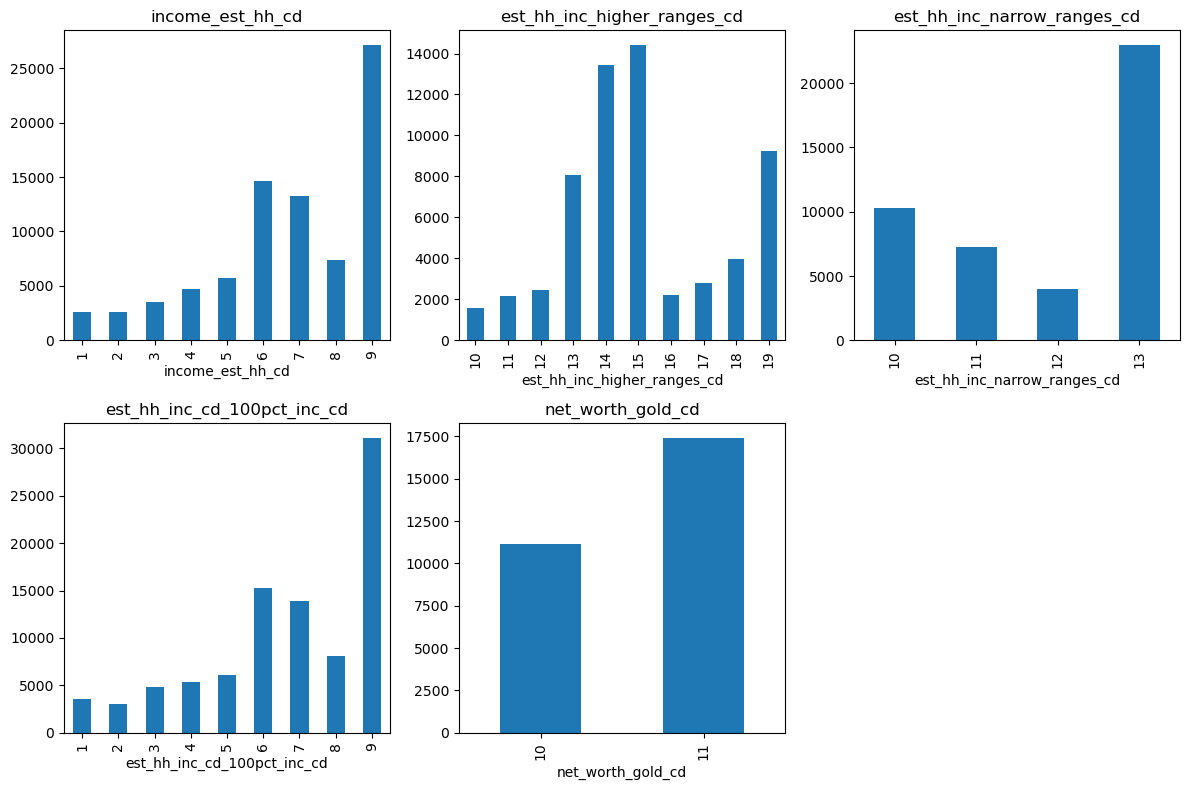

In [161]:
%%script false
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
df_liva['income_est_hh_cd'].value_counts().sort_index().plot(kind='bar')
plt.title('income_est_hh_cd')

plt.subplot(2, 3, 2)
df_liva['est_hh_inc_higher_ranges_cd'].value_counts().sort_index().plot(kind='bar')
plt.title('est_hh_inc_higher_ranges_cd')

plt.subplot(2, 3, 3)
df_liva['est_hh_inc_narrow_ranges_cd'].value_counts().sort_index().plot(kind='bar')
plt.title('est_hh_inc_narrow_ranges_cd')

plt.subplot(2, 3, 4)
df_liva['est_hh_inc_cd_100pct_inc_cd'].value_counts().sort_index().plot(kind='bar')
plt.title('est_hh_inc_cd_100pct_inc_cd')

plt.subplot(2, 3, 5)
df_liva['net_worth_gold_cd'].value_counts().sort_index().plot(kind='bar')
plt.title('net_worth_gold_cd')

plt.tight_layout()
plt.show()




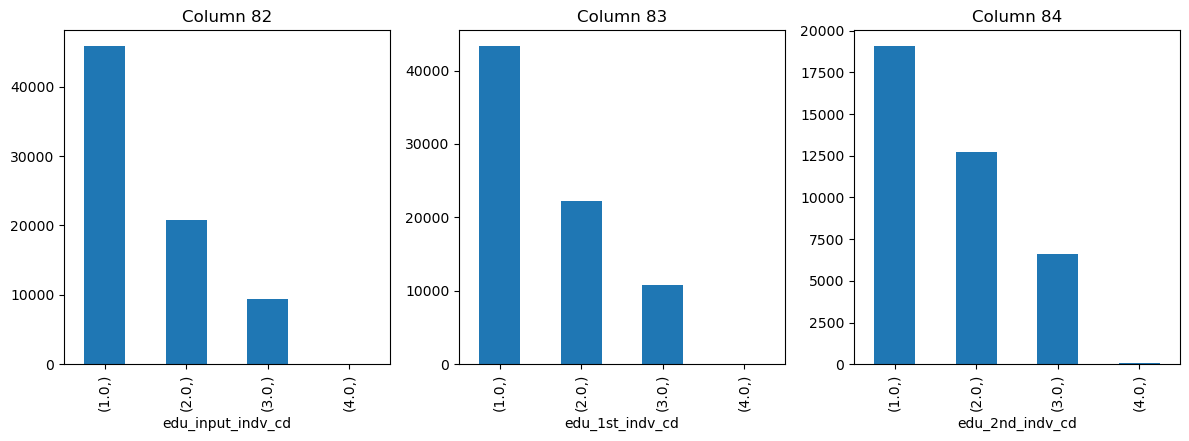

In [183]:
%%script false
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
df_liva.iloc[:, 82:83].value_counts().sort_index().plot(kind='bar')
plt.title('Column 82')

plt.subplot(2, 3, 2)
df_liva.iloc[:, 83:84].value_counts().sort_index().plot(kind='bar')
plt.title('Column 83')

plt.subplot(2, 3, 3)
df_liva.iloc[:, 84:85].value_counts().sort_index().plot(kind='bar')
plt.title('Column 84')

plt.tight_layout()
plt.show()

Filter for season ticketholder attendees

In [317]:
df_season_liva = df_liva[df_liva['cust_email_addr'].isin(season_tickets['attendee_email']) | df_liva['cust_email_addr'].isin(season_tickets['purchaser_email'])]


In [318]:
len(df_season_liva)

128514

In [319]:
len(df_liva)

128900

##  Promotional Data

In [320]:
df_promos = pd.read_csv("data/raw/Bulls Theme + Giveaway Schedules.csv"
                        ,
                        names = ['event_date', 'opponent', 'start_ct', 'dameday_offer', 'primary_theme_partner', 'giveaway_partner', 'item_of_the_game']
                        , header = 0
                        )
df_promos['event_date'] = pd.to_datetime(df_promos['event_date'], format = "%m/%d/%y")

In [321]:
df_promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   event_date             80 non-null     datetime64[ns]
 1   opponent               80 non-null     object        
 2   start_ct               80 non-null     object        
 3   dameday_offer          10 non-null     object        
 4   primary_theme_partner  58 non-null     object        
 5   giveaway_partner       32 non-null     object        
 6   item_of_the_game       80 non-null     object        
dtypes: datetime64[ns](1), object(6)
memory usage: 53.0+ KB


In [322]:
df_promos.head()

,event_date,opponent,start_ct,dameday_offer,primary_theme_partner,giveaway_partner,item_of_the_game
0,2022-10-04,New Orleans,8:30 PM,NaN,Windy City Bulls Night,NaN,PRIMARY LOGO TEES
1,2022-10-07,Denver,7:00 PM,NaN,NaN,NaN,PRIMARY LOGO TEES
2,2022-10-11,Milwaukee,7:00 PM,NaN,NaN,NaN,POSTCARD TEES
3,2022-10-22,Cleveland,7:00 PM,NaN,Home Opener (AT&T),T-Shirt (AT&T),Sportiqe Chicago Script Hoodie
4,2022-10-24,Boston,7:00 PM,Starting Five Menu,NaN,NaN,PRIMARY LOGO TEES


## Export Data

In [307]:
season_tickets.to_csv('data/processed/season_tickets.csv', index = False)
home_games.to_csv('data/processed/home_games.csv', index = False)
df_season_emails_send.to_csv('data/processed/season_email_send.csv', index = False)
df_season_emails_ctr.to_csv('data/processed/season_email_ctr.csv', index = False)
df_season_liva.to_csv('data/processed/season_liva.csv', index = False)

In [324]:
season_tickets.to_parquet('data/processed/season_tickets.parquet', index=False)
home_games.to_parquet('data/processed/home_games.parquet', index=False)
df_season_emails_send.to_parquet('data/processed/season_email_send.parquet', index=False)
df_season_emails_ctr.to_parquet('data/processed/season_email_ctr.parquet', index=False)
df_season_liva.to_parquet('data/processed/liv_a.parquet', index=False)